In [2]:
import os                                               # for working with files
import numpy as np                                      # for numerical computationss
import pandas as pd                                     # for working with dataframes
import torch                                            # Pytorch module
import gc                                               # for garbage collection
import seaborn as sns
import matplotlib.pyplot as plt                         # for plotting informations on graph and images using tensors
import torch.nn as nn                                   # for creating  neural networks
from torch.utils.data import DataLoader                 # for dataloaders 
from PIL import Image                                   # for checking images
import torch.nn.functional as F                         # for functions for calculating loss
import torchvision.transforms as transforms             # for transforming images into tensors 
from torchvision.utils import make_grid                 # for data checking
from torchvision.datasets import ImageFolder            # for working with classes and images
import torchvision.models as models                     # for pretrained models
from torchsummary import summary                        # for getting the summary of our model
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from yellowbrick.style import set_palette

In [3]:
data_dir = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [4]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [5]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

# setting the batch size
batch_size = 8

# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [6]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [9]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# base class for the model
def training_step(model, batch):
    images, labels = batch
    out = model(images)                       # Generate predictions
    loss = F.cross_entropy(out, labels)       # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch
    out = model(images)                        # Generate prediction
    loss = F.cross_entropy(out, labels)        # Calculate loss
    acc = accuracy(out, labels)                # Calculate accuracy

    _, preds = torch.max(out, dim=1)
    return {"val_loss": loss.detach(), "val_accuracy": acc, "preds": preds, "labels": labels}

def validation_epoch_end(outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    batch_accuracy = [x["val_accuracy"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
    epoch_accuracy = torch.stack(batch_accuracy).mean()

    all_preds = torch.cat([x['preds'] for x in outputs], dim=0)
    all_labels = torch.cat([x['labels'] for x in outputs], dim=0)

    return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy, "preds": all_preds.cpu().numpy(), "labels": all_labels.cpu().numpy()}

def epoch_end(epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.mean(out, dim=(2, 3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

In [12]:
model = ResNet34(num_classes=len(train.classes))

# moving the model to GPU
model = to_device(model, device)

# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3         [-1, 64, 256, 256]          36,864
       BatchNorm2d-4         [-1, 64, 256, 256]             128
            Conv2d-5         [-1, 64, 256, 256]          36,864
       BatchNorm2d-6         [-1, 64, 256, 256]             128
        BasicBlock-7         [-1, 64, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          36,864
       BatchNorm2d-9         [-1, 64, 256, 256]             128
           Conv2d-10         [-1, 64, 256, 256]          36,864
      BatchNorm2d-11         [-1, 64, 256, 256]             128
       BasicBlock-12         [-1, 64, 256, 256]               0
           Conv2d-13         [-1, 64, 256, 256]          36,864
      BatchNorm2d-14         [-1, 64, 2

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result)
        history.append(result)
        
    return history

In [12]:
%%time
history = [evaluate(model, valid_dl)]

CPU times: total: 4min 40s
Wall time: 5min 59s


In [13]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [14]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 1.7991, val_loss: 1.4175, val_acc: 0.6088
Epoch [1], last_lr: 0.00000, train_loss: 0.5160, val_loss: 0.2660, val_acc: 0.9255
CPU times: total: 10min 49s
Wall time: 3h 25min 39s


In [15]:
# saving the model
PATH = './models/resnet34-custom.pth'  
torch.save(model.state_dict(), PATH)

In [16]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    sns.lineplot(data=lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

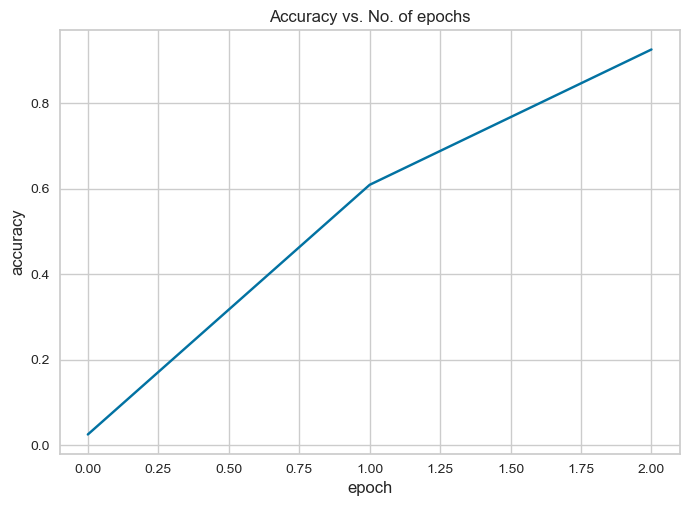

In [17]:
plot_accuracies(history)

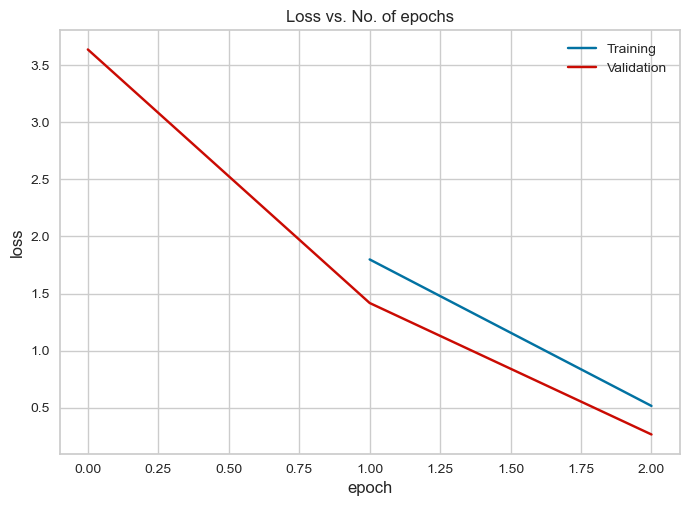

In [18]:
plot_losses(history)

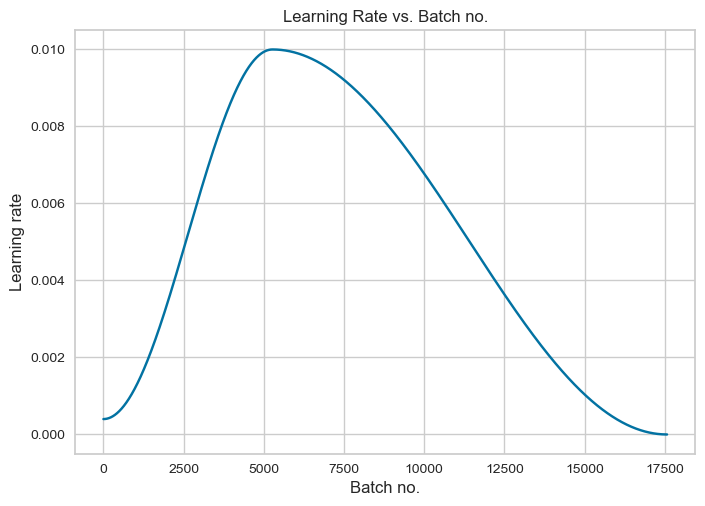

In [19]:
plot_lrs(history)

In [20]:
def obtain_performance_metrics(ground_truths, predictions):
    # Performance Metrics and Confusion Matrix
    print("Classification Report: ")
    print()
    target_names = train.classes
    print(classification_report(ground_truths, predictions, target_names=target_names))

    print("Balanced accuracy score: ")
    print(balanced_accuracy_score(ground_truths, predictions))

    print("\nConfusion Matrix: ")
    print()
    plt.figure(figsize=(20,20))
    matrix = confusion_matrix(ground_truths, predictions)
    sns.heatmap(matrix, cmap="PuBu", annot=True, linewidths=0.5, fmt= 'd')
    plt.show()


Classification Report: 

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.94      0.96       504
                                 Apple___Black_rot       0.94      0.98      0.96       497
                          Apple___Cedar_apple_rust       0.92      0.95      0.94       440
                                   Apple___healthy       0.91      0.94      0.92       502
                               Blueberry___healthy       0.93      0.93      0.93       454
          Cherry_(including_sour)___Powdery_mildew       0.96      0.96      0.96       421
                 Cherry_(including_sour)___healthy       0.90      1.00      0.94       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.80      0.87       410
                       Corn_(maize)___Common_rust_       0.94      0.97      0.95       477
               Corn_(maize)___Northern_Leaf_Blight    

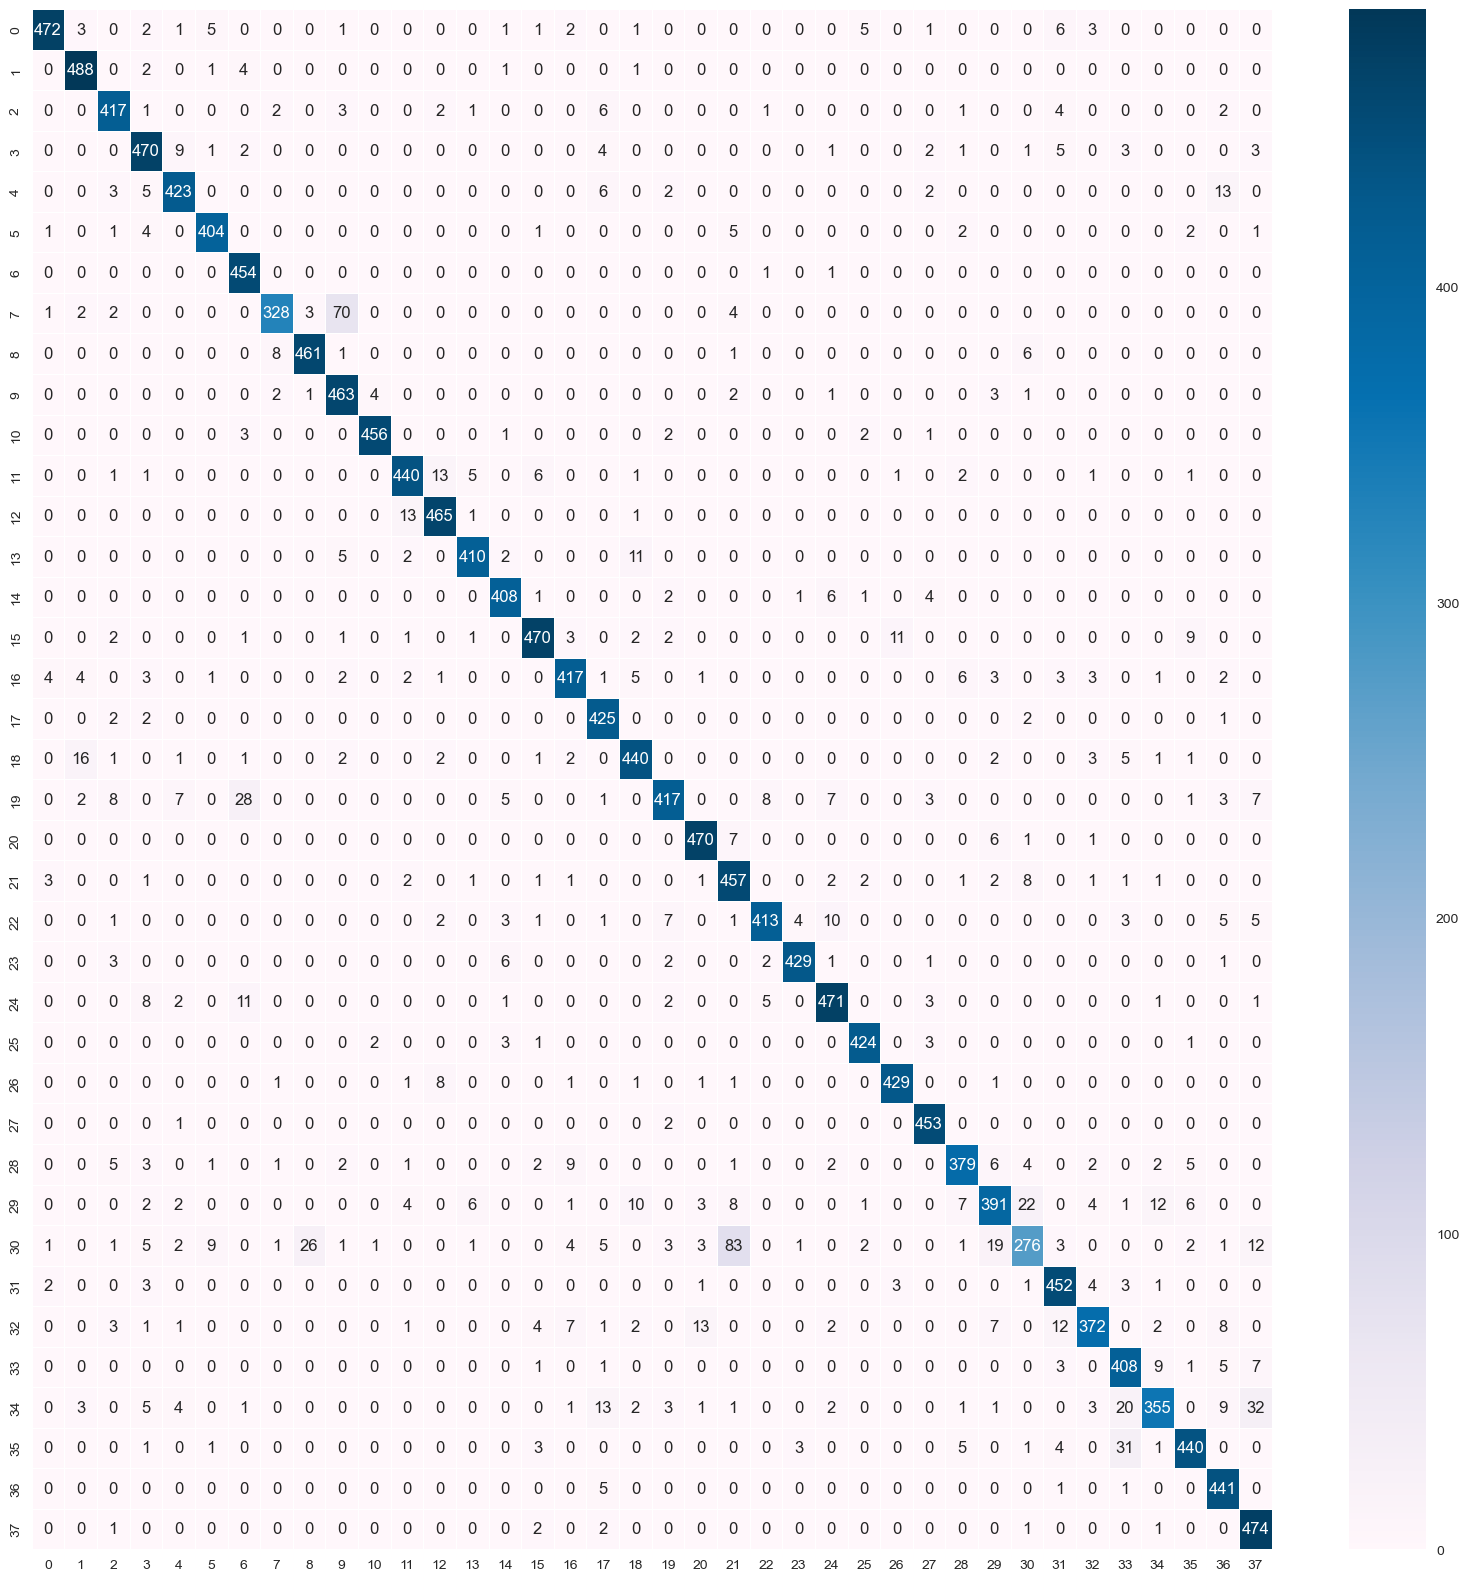

In [21]:
obtain_performance_metrics(history[2]['labels'], history[2]['preds'])